In [1]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3
cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

In [2]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [3]:
from os.path import exists
params = {}
param_names = [ 'd0', 'd1',
               'e0', 'e1',
               'f0', 'f1',
               'g0','g1']
ndim = len(param_names)
for box in cosmo_params:
    if('Box5_1400' in box):
        continue
    #check if there is a fit for this box by checking if the corresponding figure exsits
    fig_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, 1.0)
    if(not exists(fig_fname)):
        print('Skipping %s'%(box))
        continue
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    samples = sampler.chain[:, 9000:, :].reshape((-1, ndim))
    final_param_vals = np.percentile(samples,  50,axis=0)
    params[box] = dict(zip(param_names, final_param_vals))

Skipping Box12_1400
Skipping Box15_1400
Skipping Box21_1400
Skipping Box22_1400
Skipping Box35_1400
Skipping Box36_1400
Skipping Box47_1400
Skipping Box49_1400
Skipping Box50_1400
Skipping Box52_1400
Skipping Box54_1400
Skipping Box63_1400
Skipping Box70_1400
Skipping Box85_1400
Skipping Box95_1400


In [4]:
cosmo_vals = {}
for key in cosmo_params['Box_n50_0_1400']:
    cosmo_vals[key] = []
    
for box in cosmo_params:
    if(box not in params):
        continue
    for key in cosmo_vals:
        cosmo_vals[key] += [cosmo_params[box][key]]

means = {}
var = {}
for key in cosmo_vals:
    means[key] = np.mean(cosmo_vals[key]) 
    var[key] = np.var(cosmo_vals[key])

distance = []
for box in cosmo_params:
    dist = 0
    
    for key in cosmo_params[box]:
        dist += (cosmo_params[box][key] - means[key])**2/var[key]
    distance += [[dist, box]]

In [5]:
central_box = sorted(distance)[1][1] #getting second most central since the most 
                                     #central didnt seem to have convergent mcmc?

In [6]:
central_box

'Box_n50_14_1400'

In [7]:
param_names = [ 'd0', 'd1',
               'e0', 'e1',
               'f0', 'f1',
               'g0','g1']

labels = param_names

In [8]:
sampler = None
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(central_box), "rb") as f:
    sampler = pickle.load(f)

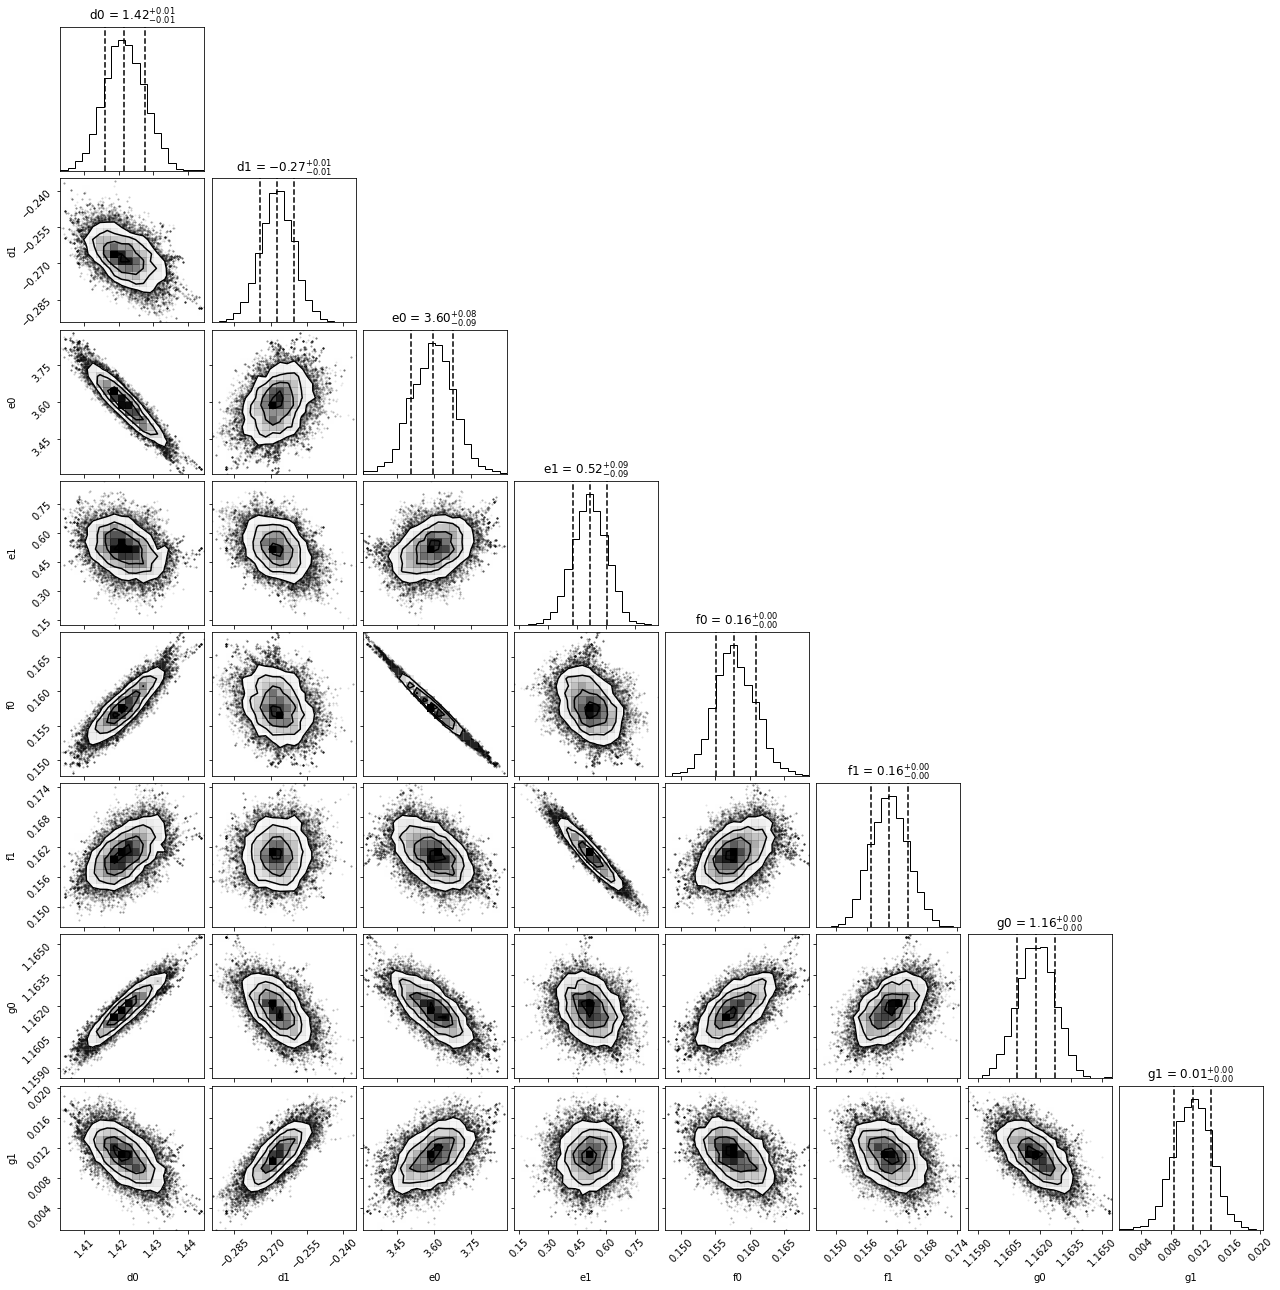

In [9]:
import corner
samples = sampler.chain[:, 9000:, :].reshape((-1, ndim))
final_param_vals = np.percentile(samples,  50,axis=0)
params_final = dict(zip(param_names, final_param_vals))
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True,)

(10000, 64, 8)


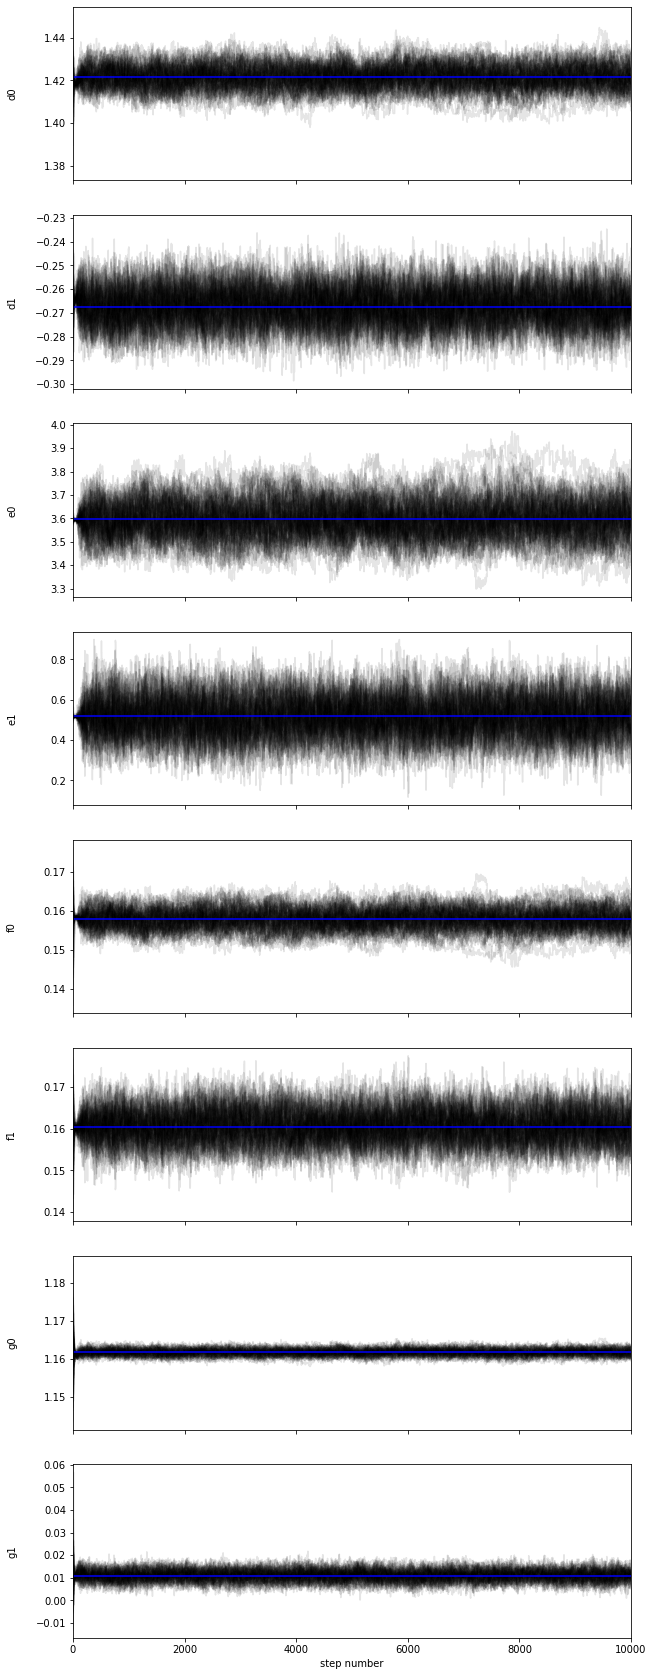

In [10]:
fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
print(np.shape(samples))
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axhline(final_param_vals[i], color='blue')
axes[-1].set_xlabel("step number");

In [11]:
# Get the chain samples
samples = sampler.get_chain(flat=True, discard=500)

# Compute the covariance matrix
cov = np.cov(samples.T)

Can diagonalize real symmetric cov matrix as 
$$K_X = R \Lambda R^T$$
Where $\Lambda$ is the matrix of eigenvalues and $R$ are eigenvectors. So we can rotate our paramters to a orthogonal frame with
$$Y = R^T X \Rightarrow K_Y = R^T K_X R = R^T R \Lambda R^T R = \Lambda$$
We also see that
$$X = R Y = R R^T X$$

In [12]:
# Get the eigendecomposition of the covariance matrix
eigvals, eigvecs = np.linalg.eigh(cov)

# Get the rotation matrix
rot_matrix = eigvecs

In [13]:
new_samples = rot_matrix.T @ samples.T
new_cov = np.cov(new_samples)
print(new_cov)

[[ 1.28749247e-08 -5.76970049e-21  8.24844455e-21  9.45922291e-21
  -2.02630146e-20  3.82873621e-20 -1.44249881e-19 -1.92931887e-19]
 [-5.76970049e-21  2.36015960e-08 -1.60477378e-21  1.40184382e-20
  -4.61112845e-20  5.17558935e-20  1.38525868e-19 -1.24785991e-19]
 [ 8.24844455e-21 -1.60477378e-21  1.09783280e-07 -2.26088328e-19
   4.93430047e-20  5.74361281e-19  1.46202942e-19  9.84042323e-19]
 [ 9.45922291e-21  1.40184382e-20 -2.26088328e-19  5.99466794e-07
   1.03592043e-19  8.18705054e-19  3.89847109e-19  1.84877959e-18]
 [-2.02630146e-20 -4.61112845e-20  4.93430047e-20  1.03592043e-19
   2.78210537e-06 -9.61154998e-20 -1.96206767e-19 -3.56368122e-19]
 [ 3.82873621e-20  5.17558935e-20  5.74361281e-19  8.18705054e-19
  -9.61154998e-20  3.96480764e-05 -2.89208552e-19 -2.36549907e-18]
 [-1.44249881e-19  1.38525868e-19  1.46202942e-19  3.89847109e-19
  -1.96206767e-19 -2.89208552e-19  4.85799748e-03  4.52923349e-19]
 [-1.92931887e-19 -1.24785991e-19  9.84042323e-19  1.84877959e-18
  -

In [14]:
#check if new cov almost diagonal
np.allclose(new_cov, np.diag(np.diagonal(new_cov)))

True

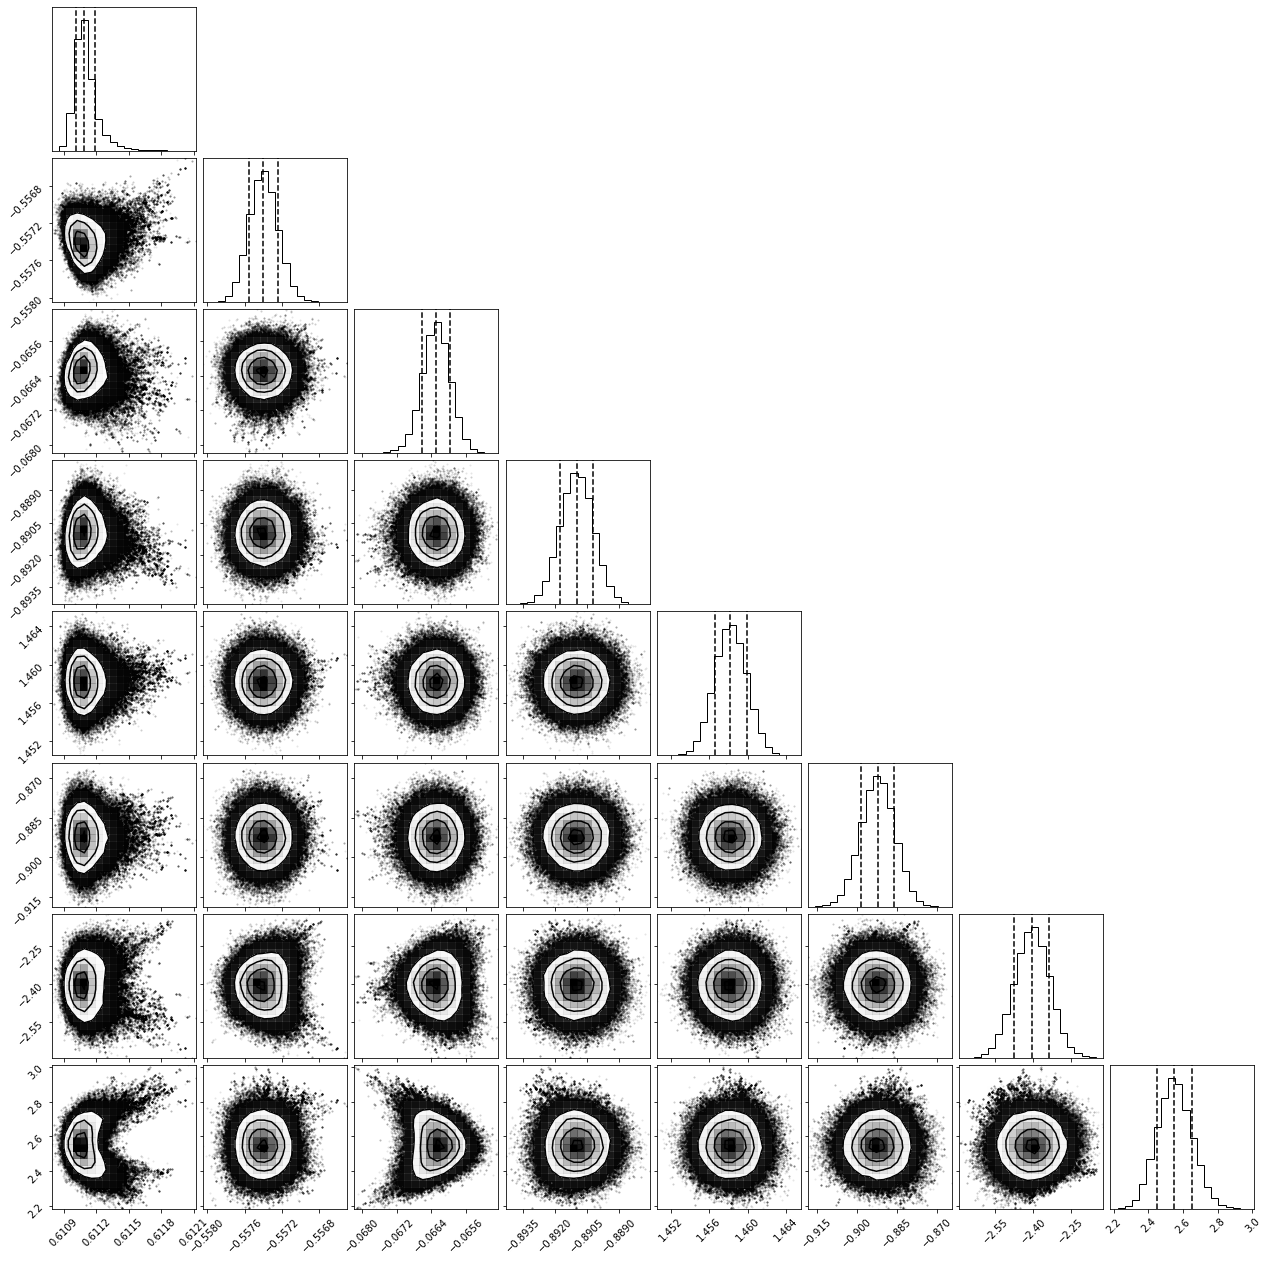

In [15]:
#look at how diagonal rotated corner plot is
import corner
fig = corner.corner(new_samples.T, quantiles=[0.16, 0.5, 0.84])

In [16]:
# sampler = None
# with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(sorted(distance)[0][1]), "rb") as f:
#     sampler = pickle.load(f)
    
# import corner
# samples = sampler.chain[:, 9000:, :].reshape((-1, ndim))
# fig = corner.corner(samples,  quantiles=[0.16, 0.5, 0.84])
# new_samples = R.T @ samples.T
# fig = corner.corner(new_samples.T, quantiles=[0.16, 0.5, 0.84])

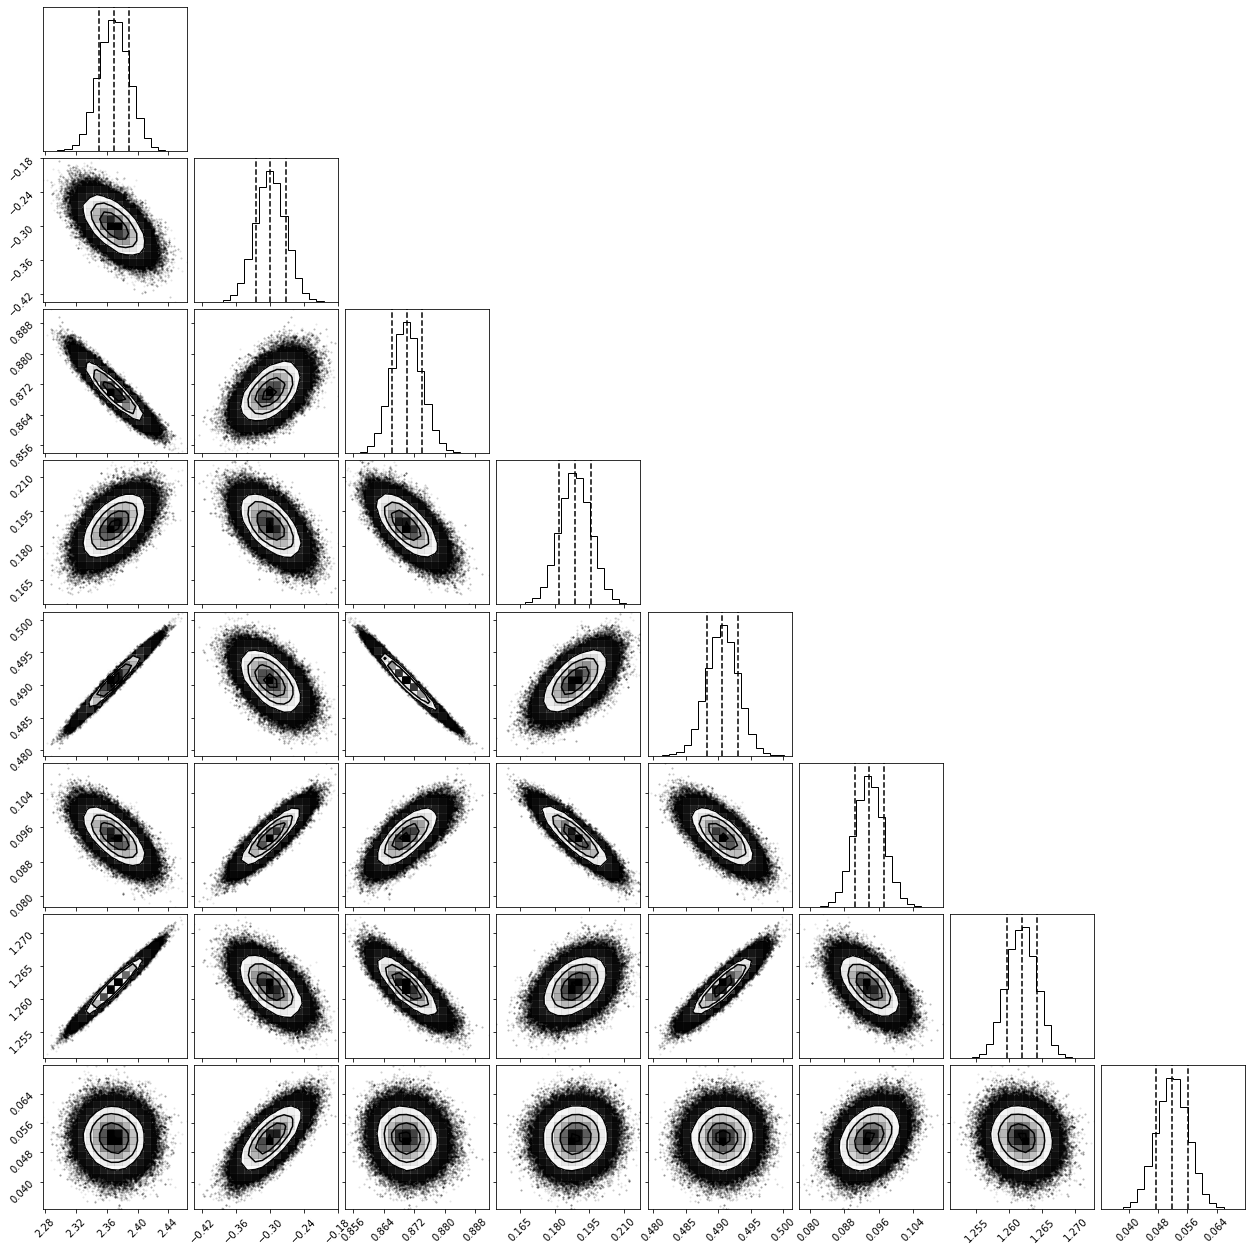

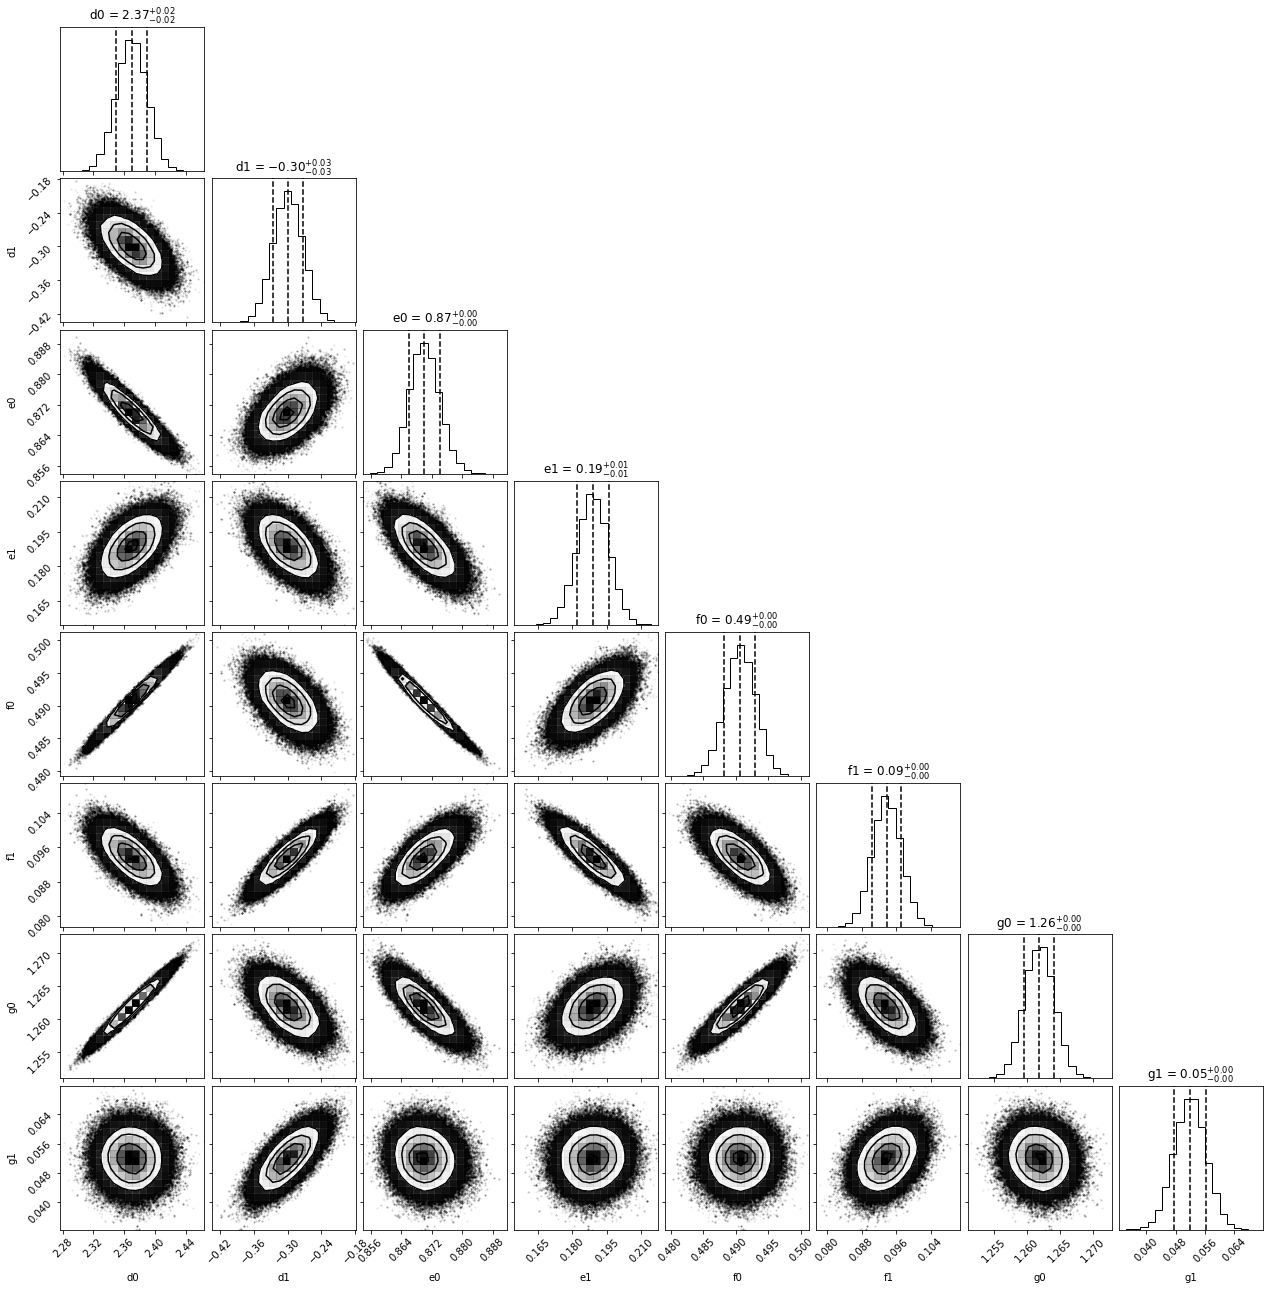

In [71]:
sampler = None
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(sorted(distance)[15][1]), "rb") as f:
    sampler = pickle.load(f)
    
import corner
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
fig = corner.corner(samples,  quantiles=[0.16, 0.5, 0.84])
# new_samples = R.T @ samples.T
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True)

In [18]:
for box in params:
    curr = np.array((list(params[box].values())))
    rotated = rot_matrix.T @ curr.T
    params[box] = dict(zip(params[box].keys(), rotated))

In [19]:
testing = []
params_testing = {}
for box in params:
    if(np.random.rand()>=0.03):
        continue
    params_testing[box] = params[box]
    testing += [box]
for box in testing:
    del params[box]
print(testing)

['Box33_1400', 'Box_n50_14_1400', 'Box_n50_35_1400', 'Box_n50_38_1400', 'Box_n50_41_1400']


In [20]:
training = list(params.keys())
print(training)

['Box0_1400', 'Box1_1400', 'Box2_1400', 'Box3_1400', 'Box4_1400', 'Box6_1400', 'Box7_1400', 'Box8_1400', 'Box9_1400', 'Box10_1400', 'Box11_1400', 'Box13_1400', 'Box14_1400', 'Box16_1400', 'Box17_1400', 'Box18_1400', 'Box19_1400', 'Box20_1400', 'Box23_1400', 'Box24_1400', 'Box25_1400', 'Box26_1400', 'Box27_1400', 'Box28_1400', 'Box29_1400', 'Box30_1400', 'Box31_1400', 'Box32_1400', 'Box34_1400', 'Box37_1400', 'Box38_1400', 'Box39_1400', 'Box40_1400', 'Box41_1400', 'Box42_1400', 'Box43_1400', 'Box44_1400', 'Box45_1400', 'Box46_1400', 'Box48_1400', 'Box51_1400', 'Box53_1400', 'Box55_1400', 'Box56_1400', 'Box57_1400', 'Box58_1400', 'Box59_1400', 'Box60_1400', 'Box61_1400', 'Box62_1400', 'Box64_1400', 'Box65_1400', 'Box66_1400', 'Box67_1400', 'Box68_1400', 'Box69_1400', 'Box71_1400', 'Box72_1400', 'Box73_1400', 'Box74_1400', 'Box75_1400', 'Box76_1400', 'Box77_1400', 'Box78_1400', 'Box79_1400', 'Box80_1400', 'Box81_1400', 'Box82_1400', 'Box83_1400', 'Box84_1400', 'Box86_1400', 'Box87_1400', 

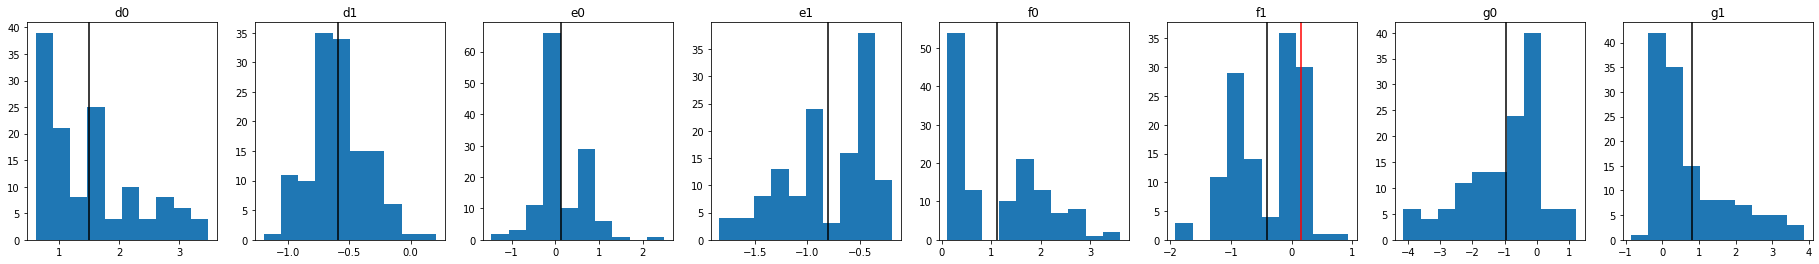

In [70]:
tinker_vals = {}
for key in params[list(params.keys())[0]]:
    tinker_vals[key] = []
    
for box in params:
    for key in tinker_vals:
        tinker_vals[key] += [params[box][key]]

fig, axs = plt.subplots(ncols=len(tinker_vals.keys()), figsize=(32, 4))
for (idx, key) in enumerate(tinker_vals):
    axs[idx].hist(tinker_vals[key])
    axs[idx].axvline(np.mean(tinker_vals[key]), color='black')
    if(key == 'f1'):
        axs[idx].axvline(0.16, color='red')

    axs[idx].set_title(key)

In [66]:
from tqdm import trange, tqdm
tinker_stds = {}
for key in params[list(params.keys())[0]]:
    tinker_stds[key] = []
    
for box in tqdm(params):
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
    samples = rot_matrix.T @ samples.T
    final_param_vals = np.std(samples,axis=0)
    params_final = dict(zip(param_names, final_param_vals))
    for key in tinker_vals:
        tinker_stds[key] += [params_final[key]]

100%|██████████| 129/129 [00:26<00:00,  4.84it/s]


In [67]:
for key in tinker_stds:
    print(key, np.mean(tinker_stds[key]), np.mean(tinker_vals[key]))

d0 1.0747429118841367 1.4940136670312187
d1 1.0745432155655932 -0.5941996294649449
e0 1.0742817686357973 0.1332276879407074
e1 1.0744640101856135 -0.808805205215909
f0 1.0744613935804619 1.123591204621155
f1 1.0739009719421104 -0.3988876474346115
g0 1.0741302852993393 -0.9457788247733941
g1 1.0741607682169132 0.7977823814252555


In [26]:
cosmo_vals = {}
for key in cosmo_params['Box_n50_0_1400']:
    cosmo_vals[key] = []
    
for box in cosmo_params:
    if(box not in params):
        continue
    for key in cosmo_vals:
        cosmo_vals[key] += [cosmo_params[box][key]]

means = {}
var = {}
for key in cosmo_vals:
    means[key] = np.mean(cosmo_vals[key]) 
    var[key] = np.var(cosmo_vals[key])

distance = []
for box in cosmo_params:
    dist = 0
    
    for key in cosmo_params[box]:
        dist += (cosmo_params[box][key] - means[key])**2/var[key]
    distance += [[dist, box]]

In [27]:
import george

In [28]:
gps = {}

hyperparams = [np.std(cosmo_vals[key]) for key in cosmo_vals]

array_list = list(cosmo_vals.values())
# use numpy to create a 2D matrix from the list of arrays
matrix = np.vstack(array_list).T
print(matrix.shape)
print(np.shape(tinker_stds['d0']))
for key in tinker_vals:
    kernel = george.kernels.ExpSquaredKernel(hyperparams, 
                                             ndim=len(cosmo_vals.keys()))
    
    gps[key] = george.GP(kernel, mean=np.mean(tinker_vals[key]), white_noise=np.log(np.mean(tinker_stds[key])**2))
    gps[key].compute(matrix, tinker_stds[key])


(129, 8)
(129,)


In [29]:
from scipy.optimize import minimize
for key in tinker_vals:
    y = tinker_vals[key]
    gp = gps[key]
    def nll(p):
        gp.set_parameter_vector(p)
        ll = gp.log_likelihood(y, quiet=True)
        if(not np.isfinite(ll)):
            return np.inf
        return -ll
    def grad_nll(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y, quiet=True)
    p0 = gp.get_parameter_vector()
    result = minimize(nll, p0, method="Nelder-Mead")#, jac=grad_nll)
    gp.set_parameter_vector(result.x)


In [30]:
for test_box in params_testing:
    cosmo = (list(cosmo_params[test_box].values()))
    cosmo = np.atleast_2d(cosmo)
    for key in gps:
        print(key, gps[key].predict(tinker_vals[key], cosmo)[0])
    print(params_testing[test_box])

d0 [1.48226765]
d1 [-0.6121927]
e0 [0.19908431]
e1 [-0.77353635]
f0 [1.01845588]
f1 [-0.32696524]
g0 [-0.69788904]
g1 [0.63813482]
{'d0': 1.8733213790504049, 'd1': -0.7210654216518173, 'e0': 0.7020059959911031, 'e1': -0.4868106741090107, 'f0': 0.20789576288427047, 'f1': 0.08939173515356497, 'g0': 0.06423991761109953, 'g1': -0.03814697358897105}
d0 [1.47591594]
d1 [-0.6121927]
e0 [0.19908431]
e1 [-0.77353635]
f0 [1.01845588]
f1 [-0.32696524]
g0 [-0.69788904]
g1 [0.63813482]
{'d0': 0.6110402028519051, 'd1': -0.5573920224218518, 'e0': -0.0662166618111984, 'e1': -0.8910049772207103, 'f0': 1.458270772674323, 'f1': -0.8924263392381437, 'g0': -2.404325856314539, 'g1': 2.5513450551716623}
d0 [1.46651636]
d1 [-0.6121927]
e0 [0.19908431]
e1 [-0.77353635]
f0 [1.01845588]
f1 [-0.32696524]
g0 [-0.69788904]
g1 [0.63813482]
{'d0': 2.515041009565511, 'd1': -0.8095621022929576, 'e0': 0.06328196390463164, 'e1': -0.4759839350703572, 'f0': 0.4356602077093831, 'f1': -0.003876489754746037, 'g0': -0.80997097

In [31]:
from scipy.special import gamma

def p(a, p0, p1):
    oup = (p0)+(a-0.5)*(p1)
    return oup

def B(a, M, σM, d, e, f, g):
    oup = e**(d)*g**(-d/2)*gamma(d/2)
    oup += g**(-f/2)*gamma(f/2)
    oup = 2/oup
    return oup
    
    
def f_G(a, M, σM, d, e, f, g):
    oup = B(a, M, σM, d, e, f, g)
    oup *= ((σM/e)**(-d)+σM**(-f))
    oup *= np.exp(-g/σM**2)
    return oup


ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3

def M_to_R(M, box, a):
    """
    Converts mass of top-hat filter to radius of top-hat filter
    
    Parameters:
        - M (float): Mass of the top hat filter in units Msolor/h
        - box (string): Which Aemulus nu box we're considering 
        - a (float): Redshift 

    Returns:
        - R (float): Corresponding radius of top hat filter Mpc/h
    """

    return (M / (4/3 * math.pi * rhom_a(box, a))) ** (1/3) # h^-1 Mpc  
def rhom_a(box, a):
    ombh2 = cosmo_params[box]['ombh2']
    omch2 = cosmo_params[box]['omch2']
    H0 = cosmo_params[box]['H0'] #[km s^-1 Mpc-1]
    h = H0/100 

    Ωm = ombh2/h**2 + omch2/h**2
    
    ΩDE = 1 - Ωm
    wDE = cosmo_params[box]['w0'] #'wa' is zero for us
    #0xx
#     return Ωm*ρcrit0*(Ωm*a**(-3) + ΩDE*a**(-3*(1+wDE))) * a**3 # h^2 Msol/Mpc^3

    #1xx
    return Ωm*ρcrit0

In [32]:
with open('training_boxes.txt', 'w') as file:
    for item in training:
        file.write(str(item) + '\n')

In [33]:
with open('testing_boxes.txt', 'w') as file:
    for item in testing:
        file.write(str(item) + '\n')

In [34]:
with open("gps.pkl", "wb") as f:
    pickle.dump((gps,tinker_vals, rot_matrix), f)

d0 [1.48226765]
d1 [-0.6121927]
e0 [0.19908431]
e1 [-0.77353635]
f0 [1.01845588]
f1 [-0.32696524]
g0 [-0.69788904]
g1 [0.63813482]
(8,) (8, 8)
{'d0': 1.8733213790504049, 'd1': -0.7210654216518173, 'e0': 0.7020059959911031, 'e1': -0.4868106741090107, 'f0': 0.20789576288427047, 'f1': 0.08939173515356497, 'g0': 0.06423991761109953, 'g1': -0.03814697358897105}


  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_13472/2522907452.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
100%|██████████| 200/200 [00:04<00:00, 40.90it/s]


(8,) (8, 8)
{'d0': 1.8733213790504049, 'd1': -0.7210654216518173, 'e0': 0.7020059959911031, 'e1': -0.4868106741090107, 'f0': 0.20789576288427047, 'f1': 0.08939173515356497, 'g0': 0.06423991761109953, 'g1': -0.03814697358897105}


100%|██████████| 200/200 [00:00<00:00, 80327.57it/s]
/tmp/ipykernel_13472/2522907452.py:132: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


(200,) (200,)


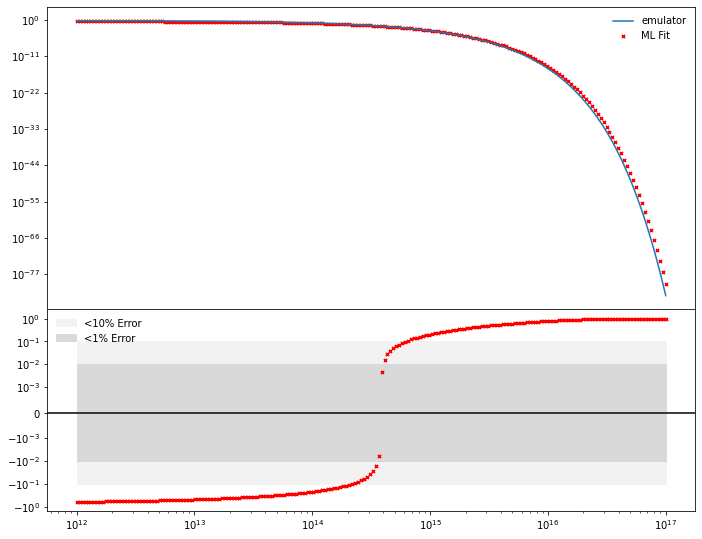

d0 [1.47591594]
d1 [-0.6121927]
e0 [0.19908431]
e1 [-0.77353635]
f0 [1.01845588]
f1 [-0.32696524]
g0 [-0.69788904]
g1 [0.63813482]
(8,) (8, 8)
{'d0': 0.6110402028519051, 'd1': -0.5573920224218518, 'e0': -0.0662166618111984, 'e1': -0.8910049772207103, 'f0': 1.458270772674323, 'f1': -0.8924263392381437, 'g0': -2.404325856314539, 'g1': 2.5513450551716623}


100%|██████████| 200/200 [00:04<00:00, 41.23it/s]


(8,) (8, 8)
{'d0': 0.6110402028519051, 'd1': -0.5573920224218518, 'e0': -0.0662166618111984, 'e1': -0.8910049772207103, 'f0': 1.458270772674323, 'f1': -0.8924263392381437, 'g0': -2.404325856314539, 'g1': 2.5513450551716623}


100%|██████████| 200/200 [00:00<00:00, 102763.79it/s]


(200,) (200,)


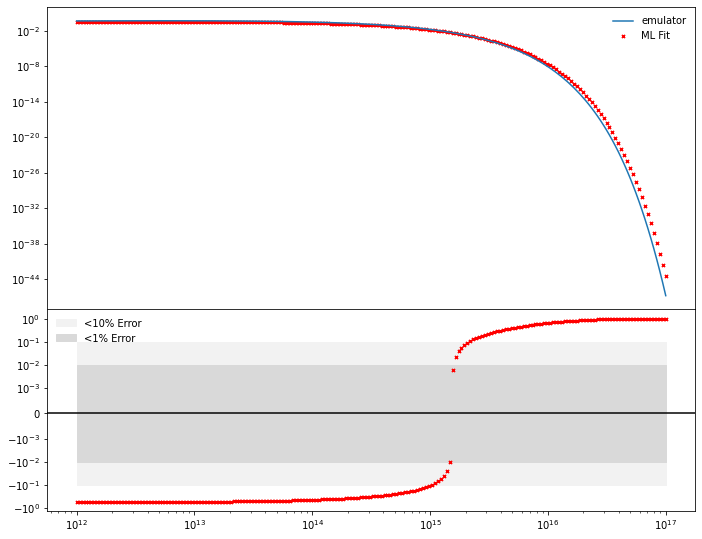

d0 [1.46651636]
d1 [-0.6121927]
e0 [0.19908431]
e1 [-0.77353635]
f0 [1.01845588]
f1 [-0.32696524]
g0 [-0.69788904]
g1 [0.63813482]
(8,) (8, 8)
{'d0': 2.515041009565511, 'd1': -0.8095621022929576, 'e0': 0.06328196390463164, 'e1': -0.4759839350703572, 'f0': 0.4356602077093831, 'f1': -0.003876489754746037, 'g0': -0.8099709777854199, 'g1': 0.6117313136164658}


100%|██████████| 200/200 [00:04<00:00, 40.69it/s]


(8,) (8, 8)
{'d0': 2.515041009565511, 'd1': -0.8095621022929576, 'e0': 0.06328196390463164, 'e1': -0.4759839350703572, 'f0': 0.4356602077093831, 'f1': -0.003876489754746037, 'g0': -0.8099709777854199, 'g1': 0.6117313136164658}


100%|██████████| 200/200 [00:00<00:00, 100800.38it/s]


(200,) (200,)


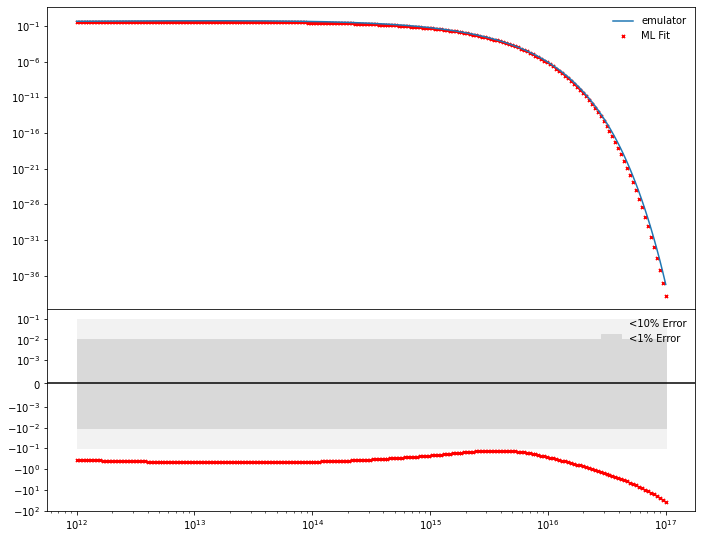

d0 [1.4808359]
d1 [-0.6121927]
e0 [0.19908431]
e1 [-0.77353635]
f0 [1.01845588]
f1 [-0.32696524]
g0 [-0.69788904]
g1 [0.63813482]
(8,) (8, 8)
{'d0': 1.8769286174113298, 'd1': -1.0450824959650442, 'e0': 0.3019275076316562, 'e1': 0.029817992182772986, 'f0': 0.3799831768873531, 'f1': 0.10518613092895336, 'g0': 0.04564132270453248, 'g1': -0.04767307432054056}


100%|██████████| 200/200 [00:04<00:00, 41.62it/s]


(8,) (8, 8)
{'d0': 1.8769286174113298, 'd1': -1.0450824959650442, 'e0': 0.3019275076316562, 'e1': 0.029817992182772986, 'f0': 0.3799831768873531, 'f1': 0.10518613092895336, 'g0': 0.04564132270453248, 'g1': -0.04767307432054056}


  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_13472/1367568871.py:8: RuntimeWarning: invalid value encountered in scalar power
  oup = e**(d)*g**(-d/2)*gamma(d/2)
/tmp/ipykernel_13472/1367568871.py:16: RuntimeWarning: invalid value encountered in scalar power
  oup *= ((σM/e)**(-d)+σM**(-f))
100%|██████████| 200/200 [00:00<00:00, 11093.11it/s]


(200,) (200,)


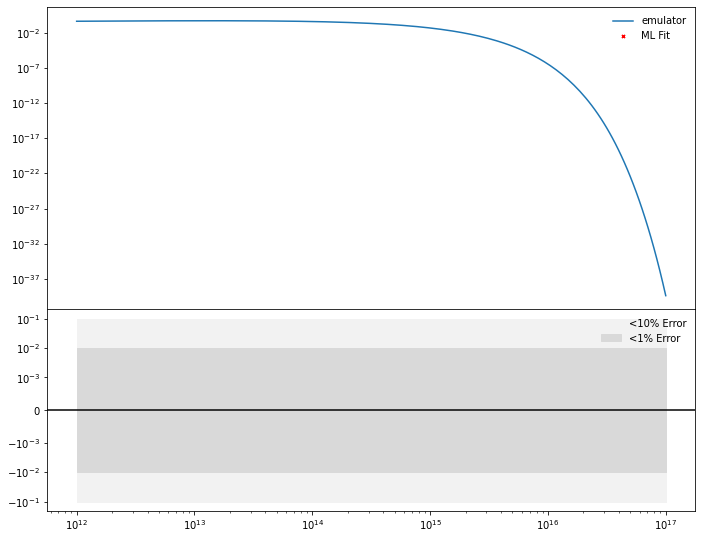

d0 [1.52630226]
d1 [-0.6121927]
e0 [0.19908431]
e1 [-0.77353635]
f0 [1.01845588]
f1 [-0.32696524]
g0 [-0.69788904]
g1 [0.63813482]
(8,) (8, 8)
{'d0': 2.6088500980332325, 'd1': -0.607011347683857, 'e0': 0.39477029084726756, 'e1': -0.5654794454695355, 'f0': 0.4089352935846441, 'f1': -0.046680512881703225, 'g0': -1.6308567386299258, 'g1': 0.9141338694933314}


100%|██████████| 200/200 [00:04<00:00, 41.81it/s]


(8,) (8, 8)
{'d0': 2.6088500980332325, 'd1': -0.607011347683857, 'e0': 0.39477029084726756, 'e1': -0.5654794454695355, 'f0': 0.4089352935846441, 'f1': -0.046680512881703225, 'g0': -1.6308567386299258, 'g1': 0.9141338694933314}


100%|██████████| 200/200 [00:00<00:00, 107079.50it/s]


(200,) (200,)


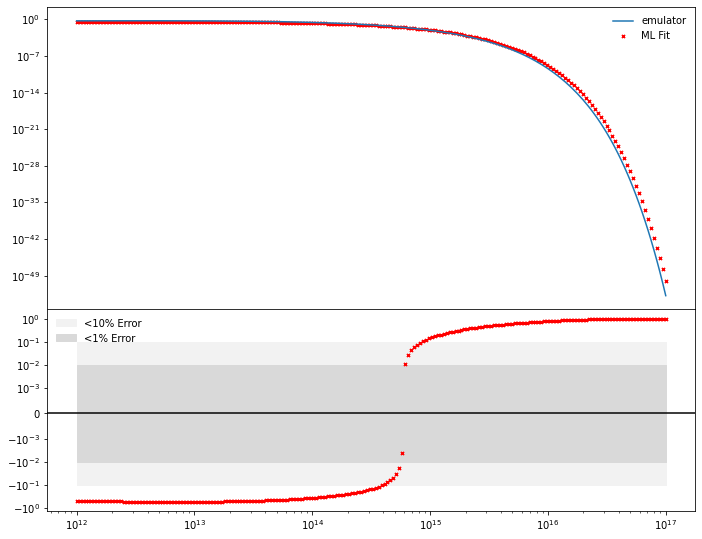

In [61]:
@functools.cache
def sigma2(pk, R):
    """
    Adapated from https://github.com/komatsu5147/MatterPower.jl
    Computes variance of mass fluctuations with top hat filter of radius R
    For this function let k be the comoving wave number with units h/Mpc

    Parameters:
        - pk (funtion): P(k), the matter power spectrum which has units Mpc^3 / h^3
        - R (float): The smoothing scale in units Mpc/h
    Returns:
        - sigma2 (float): The variance of mass fluctuations
    """

    def dσ2dk(k):
        x = k * R
        W = (3 / x) * (np.sin(x) / x**2 - np.cos(x) / x)
        dσ2dk = W**2 * pk(k) * k**2 / 2 / np.pi**2
        return dσ2dk
    res, err = quad(dσ2dk, 0, np.inf)
    σ2 = res
    return σ2
from classy import Class

for test_box in params_testing:
    cosmo = cosmo_params[test_box]
    h = cosmo['H0']/100
    cosmo_dict = {
        'h': h,
        'Omega_b': cosmo['ombh2'] / h**2,
        'Omega_cdm': cosmo['omch2'] / h**2,
        'N_ur': 0.00641,
        'N_ncdm': 1,
        'output': 'mPk mTk',
        'z_pk': '0.0,99',
        'P_k_max_h/Mpc': 20.,
        'm_ncdm': cosmo['nu_mass_ev']/3,
        'deg_ncdm': 3,
        'T_cmb': 2.7255,
        'A_s': cosmo['As'] * 10**-9,
        'n_s': cosmo['ns'],
        'Omega_Lambda': 0.0,
        'w0_fld': cosmo['w0'],
        'wa_fld': 0.0,
        'cs2_fld': 1.0,
        'fluid_equation_of_state': "CLP"
    }
    pkclass = Class()
    pkclass.set(cosmo_dict)
    pkclass.compute()
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]

    cosmo = (list(cosmo_params[test_box].values()))
    cosmo = np.atleast_2d(cosmo)
    for key in gps:
        print(key, gps[key].predict(tinker_vals[key], cosmo)[0])
    kt = np.logspace(-3, 1, 100) # h/Mpc
    pk_m_lin = np.array(
        [
            pkclass.pk_lin(ki, np.array([0]))*h**3 #units of Mpc^3/h^3
            for ki in kt * h # 1 / Mpc
        ]
    )
    
    cosmo = (list(cosmo_params[test_box].values()))
    cosmo = np.atleast_2d(cosmo)
    
    gp_predict = {}
    for key in gps:
        gp_predict[key] =  gps[key].predict(tinker_vals[key], cosmo)[0][0]
    curr = np.array(list(gp_predict.values()))
    print(np.shape(curr), np.shape(rot_matrix))
    unrotated = rot_matrix @ curr
    gp_predict = dict(zip(gp_predict.keys(), unrotated))
    print(params_testing[test_box])
    
    
    from scipy.interpolate import interp1d
    #given k in units of h/Mpc gives Pk in units of Mpc^3/h^3 
    Pk = interp1d(kt, pk_m_lin, kind='linear', bounds_error=False, fill_value=0.)
    a = 1.0
    d = p(a, gp_predict['d0'], gp_predict['d1'])
    e = p(a, gp_predict['e0'], gp_predict['e1'])
    f = p(a, gp_predict['f0'], gp_predict['f1'])
    g = p(a, gp_predict['g0'], gp_predict['g1'])
    M_numerics = np.logspace(12, 17, 200)
    tinker_eval0 = []
    for M in tqdm(M_numerics):
        R = M_to_R(M, test_box, a) #Mpc/h
        σM = np.sqrt(sigma2(Pk, R)) 
        tinker_eval0 += [f_G(a,M,σM,d,e,f,g)]
    axs[0].plot(M_numerics, tinker_eval0, label='emulator')
    
    gp_predict = params_testing[test_box]
    curr = np.array(list(gp_predict.values()))
    print(np.shape(curr), np.shape(rot_matrix))
    unrotated = rot_matrix @ curr
    gp_predict = dict(zip(gp_predict.keys(), unrotated))
    print(params_testing[test_box])
    
    d = p(a, gp_predict['d0'], gp_predict['d1'])
    e = p(a, gp_predict['e0'], gp_predict['e1'])
    f = p(a, gp_predict['f0'], gp_predict['f1'])
    g = p(a, gp_predict['g0'], gp_predict['g1'])
    M_numerics = np.logspace(12, 17, 200)
    tinker_eval = []
    for M in tqdm(M_numerics):
        R = M_to_R(M, test_box, a) #Mpc/h
        σM = np.sqrt(sigma2(Pk, R)) 
        tinker_eval += [f_G(a,M,σM,d,e,f,g)]
    axs[0].scatter(M_numerics, tinker_eval, s=10 , marker='x', c='red',
                label='ML Fit')
    print(np.shape(tinker_eval), np.shape(tinker_eval0))
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[1].set_xscale('log')
    y1 = 0.1
    y2 = -0.1

    axs[1].fill_between(M_numerics, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01
    y2 = -0.01

    axs[1].fill_between(M_numerics, y1, y2, alpha=1, color='0.85',label='<1% Error')
    axs[1].scatter(M_numerics, (np.array(tinker_eval)-np.array(tinker_eval0))/np.array(tinker_eval), marker='x', c='red', s=10)

    axs[1].set_yscale('symlog', linthresh=1e-3)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[0].legend(frameon=False)
    plt.show()

In [ ]:
training
testing
gps

In [ ]:
params

In [ ]:
training

In [ ]:
cosmo_params

In [ ]:
test_box = 'Box_n50_0_1400'
cosmo = cosmo_params[test_box]
h = cosmo['H0']/100
cosmo_dict = {
    'h': h,
    'Omega_b': cosmo['ombh2'] / h**2,
    'Omega_cdm': cosmo['omch2'] / h**2,
    'N_ur': 0.00641,
    'N_ncdm': 1,
    'output': 'mPk mTk',
    'z_pk': '0.0,99',
    'P_k_max_h/Mpc': 20.,
    'm_ncdm': cosmo['nu_mass_ev']/3,
    'deg_ncdm': 3,
    'T_cmb': 2.7255,
    'A_s': cosmo['As'] * 10**-9,
    'n_s': cosmo['ns'],
    'Omega_Lambda': 0.0,
    'w0_fld': cosmo['w0'],
    'wa_fld': 0.0,
    'cs2_fld': 1.0,
    'fluid_equation_of_state': "CLP"
}
pkclass = Class()
pkclass.set(cosmo_dict)
pkclass.compute()


cosmo = (list(cosmo_params[test_box].values()))
cosmo = np.atleast_2d(cosmo)
for key in gps:
    print(key, gps[key].predict(tinker_vals[key], cosmo)[0])
kt = np.logspace(-3, 1, 100) # h/Mpc
pk_m_lin = np.array(
    [
        pkclass.pk_lin(ki, np.array([0]))*h**3 #units of Mpc^3/h^3
        for ki in kt * h # 1 / Mpc
    ]
)

cosmo = (list(cosmo_params[test_box].values()))
cosmo = np.atleast_2d(cosmo)

gp_predict = {}
for key in gps:
    gp_predict[key] =  gps[key].predict(tinker_vals[key], cosmo)[0]
print(params[test_box])


from scipy.interpolate import interp1d
#given k in units of h/Mpc gives Pk in units of Mpc^3/h^3 
Pk = interp1d(kt, pk_m_lin, kind='linear', bounds_error=False, fill_value=0.)
a = 1.0
d = p(a, gp_predict['d0'], gp_predict['d1'])
e = p(a, gp_predict['e0'], gp_predict['e1'])
f = p(a, gp_predict['f0'], gp_predict['f1'])
g = p(a, gp_predict['g0'], gp_predict['g1'])
M_numerics = np.logspace(12, 17, 200)
tinker_eval = []
for M in tqdm(M_numerics):
    R = M_to_R(M, test_box, a) #Mpc/h
    σM = np.sqrt(sigma2(Pk, R)) 
    tinker_eval += [f_G(a,M,σM,d,e,f,g)]
plt.plot(M_numerics, tinker_eval, label='emulator')



d = p(a, params[test_box]['d0'], params[test_box]['d1'])
e = p(a, params[test_box]['e0'], params[test_box]['e1'])
f = p(a, params[test_box]['f0'], params[test_box]['f1'])
g = p(a, params[test_box]['g0'], params[test_box]['g1'])
M_numerics = np.logspace(12, 17, 200)
tinker_eval = []
for M in tqdm(M_numerics):
    R = M_to_R(M, test_box, a) #Mpc/h
    σM = np.sqrt(sigma2(Pk, R)) 
    tinker_eval += [f_G(a,M,σM,d,e,f,g)]
plt.plot(M_numerics, tinker_eval, label='ML fit')

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)
plt.show()